In [5]:
import torch
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# base 3.11.3 works

# Download MODIS data

First, download MODIS data from earthdata. We use file `moa125_2014_hp1_v01.tif` from https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0730_MEASURES_MOA2014_v01/geotiff/

You can follow these steps:
- Create file: nano ~/.netrc
- Add credentials: 
    - machine urs.earthdata.nasa.gov
    - login your_earthdata_username
    - password your_earthdata_password
- Secure file: chmod 0600 ~/.netrc
- Run: wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies --auth-no-challenge https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0730_MEASURES_MOA2014_v01/geotiff/moa125_2014_hp1_v01.tif

Next, specify the path to the file as done below:

In [12]:
tif_path_image_hr = "/home/kim/data/modis/moa125_2014_hp1_v01.tif"

# The hr image takes a while to load... (7 minutes)
with rasterio.open(tif_path_image_hr) as src:
    # Read the data (for single-band TIFs, read the first band)
    image_hr = src.read(1)

In [13]:
# Convert data format to make it compatible with PyTorch tensors
# Convert to a PyTorch tensor
# NOTE: Compression
image_hr_tensor = torch.tensor(image_hr.astype(np.float16), dtype = torch.int16)
del image_hr # Free memory

In [14]:
# Extract dims
n_rows = image_hr_tensor.shape[0]
n_columns = image_hr_tensor.shape[1]

[From the documentation](https://nsidc.org/sites/default/files/nsidc-0730-v001-userguide.pdf) we can tell that

- (minus) 3,174,450 m is the x-axis map coordinate of the center of the upper-left pixel.
- 2,406,325 m is the y-axis map coordinate of the center of the upper-left pixel.

In [15]:
print(image_hr_tensor.shape)
print()

x_min = -3174450
x_max = x_min + n_columns * 125
x = torch.linspace(start = x_min, end = x_max, steps = n_columns)
print("X shape:", x.shape)
print("Note, Antarctica is wider than it is tall.")

y_max = 2406325
y_min = y_max - n_rows * 125
# NOTE: need to go from max to min to index from top left
y = torch.linspace(start = y_max, end = y_min, steps = n_rows)
print("Y shape:", y.shape)

XX, YY = torch.meshgrid(x, y, indexing = 'xy')
XX.shape
# Order: X, Y, image

# Crashes sometimes
image_hr_grid = torch.concat((XX.unsqueeze(0), YY.unsqueeze(0), image_hr_tensor.unsqueeze(0)), dim = 0)

torch.Size([41779, 48333])

X shape: torch.Size([48333])
Note, Antarctica is wider than it is tall.
Y shape: torch.Size([41779])


In [ ]:
# function
def subset_tensor(tensor, x_min, x_max, y_min, y_max):
    """
    Subset a 3D tensor with shape (3, n_rows, n_columns) based on x and y ranges.
    """
    x_mask = (tensor[0, 0, :] >= x_min) & (tensor[0, 0, :] <= x_max)
    y_mask = (tensor[1, :, 0] >= y_min) & (tensor[1, :, 0] <= y_max)

    # Convert to indices
    x_inds = torch.where(x_mask)[0]
    y_inds = torch.where(y_mask)[0]

    # Use min/max to slice continuously
    x_min_idx, x_max_idx = x_inds[0], x_inds[-1] + 1
    y_min_idx, y_max_idx = y_inds[0], y_inds[-1] + 1

    # NOTE: WE return a clone
    return tensor[:, y_min_idx:y_max_idx, x_min_idx:x_max_idx].clone()

In [45]:
byrd_catchment_x_min = 400_000
byrd_catchment_x_max = 600_000 + 100 # adjust sice
byrd_catchment_y_min = - 950_000
byrd_catchment_y_max = - 750_000

catchment_subset = subset_tensor(
    image_hr_grid, 
    byrd_catchment_x_min, 
    byrd_catchment_x_max, 
    byrd_catchment_y_min, 
    byrd_catchment_y_max)

print(catchment_subset.shape)
torch.save(catchment_subset, 'data/modis/moa125_2014_hp1_v01_byrd_with_grid.pt')
# Check with ls -lh

torch.Size([3, 1600, 1600])


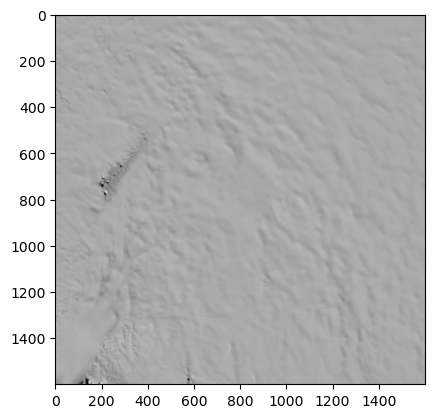

In [46]:
plt.imshow(catchment_subset[2, :, :].numpy(), cmap = 'gray')

# Export subsets

In [30]:
region = pd.read_csv("/home/kim/ice_thickness/data/real_data/corners_byrd_regions.csv")

In [38]:
row = region[region["name"] == "region_upper_byrd"]
row["y_max"].values[0]

-730000

In [41]:
row = region[region["name"] == "region_upper_byrd"]

upper = subset_tensor(
    image_hr_grid,
    x_min = row["x_min"].values[0],
    x_max = row["x_max"].values[0],
    y_min = row["y_min"].values[0],
    y_max = row["y_max"].values[0])

torch.save(upper, 'data/modis/modis_upper_byrd.pt')

row = region[region["name"] == "region_lower_byrd"]

lower = subset_tensor(
    image_hr_grid,
    x_min = row["x_min"].values[0],
    x_max = row["x_max"].values[0],
    y_min = row["y_min"].values[0],
    y_max = row["y_max"].values[0]
)

torch.save(lower, 'data/modis/modis_lower_byrd.pt')

row = region[region["name"] == "region_mid_byrd"]

mid = subset_tensor(
    image_hr_grid,
    x_min = row["x_min"].values[0],
    x_max = row["x_max"].values[0],
    y_min = row["y_min"].values[0],
    y_max = row["y_max"].values[0]
)

torch.save(mid, 'data/modis/modis_mid_byrd.pt')

# Plot

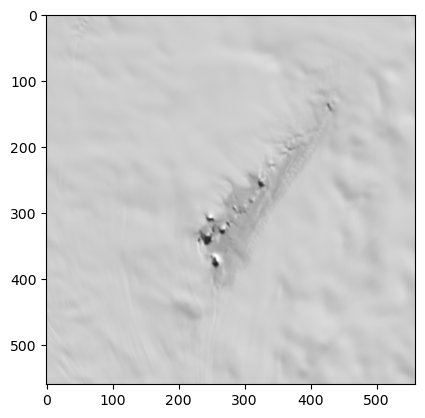

In [42]:
plt.imshow(mid[2, :, :].numpy(), cmap = 'gray', vmin = 0, vmax = 20000)

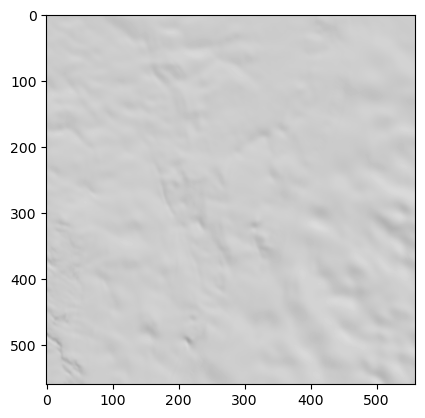

In [43]:
plt.imshow(upper[2, :, :].numpy(), cmap = 'gray', vmin = 0, vmax = 20000)

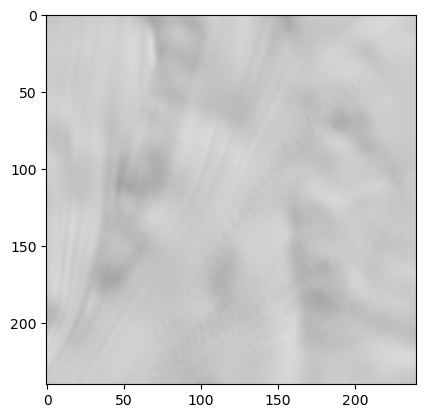

In [44]:
plt.imshow(lower[2, :, :].numpy(), cmap = 'gray', vmin = 0, vmax = 20000)